In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
from scipy import constants
# import KMS
from tqdm import tqdm
import numba

In [2]:
name = "extreme_9000"
with open(name+"/params.yaml") as f:
    param = yaml.load(f, Loader=yaml.FullLoader)
    
xyz_name = name + '/positions.xyz'
csv_name = name + '/output_data.csv'
atom = 'Ar'
param['f'] = float(param['f'])
param['tau'] = float(param['tau'])

k = constants.k*constants.N_A *1e-3

In [3]:
N = param['n']**3

b_0 = np.array((param['a'],0,0))
b_1 = np.array((param['a']/2,param['a']*np.sqrt(3)/2,0))
b_2 = np.array((param['a']/2,param['a']*np.sqrt(3)/6,param['a']*np.sqrt(2/3)))

R = np.zeros((N,3))

for i0 in range(param['n']):
    for i1 in range(param['n']):
        for i2 in range(param['n']):
            i = i0 + i1*param['n'] + i2*param['n']**2
            R[i] = (i0 - (param['n']-1)/2)*b_0 + (i1 - (param['n']-1)/2)*b_1 + (i2 - (param['n']-1)/2)*b_2

In [4]:
with open(xyz_name,'w') as f:
    f.write(f'{N}\n')
    for i, r in enumerate(R,1):
        f.write(f'\n{atom} {r[0]} {r[1]} {r[2]}')
        
with open(csv_name,'w') as f:
    f.write('t,H,V,T,P\n')

N = 5
L = 2.3
T = 0
V = -669.29

In [5]:
@numba.njit
def force_potential_pressure(R, F, L, f, e, Rparam):
    V = 0.0
    P = 0.0
    for i in range(R.shape[0]):
        r = np.linalg.norm(R[i])
        V_s = 0.0 if r < L else 0.5*f*(r-L)**2
        V += V_s
        F[i] = np.array((0.,0.,0.)) if r < L else f*(L-r)*R[i]/r
        P += np.linalg.norm(F[i])/(4*np.pi*L**2)
        for j in range(i):     # TODO
            r = np.linalg.norm(R[i] - R[j])
            V_p = e*((Rparam/r)**12 - 2*(Rparam/r)**6)
            V += V_p
            F_p = 12*e*((Rparam/r)**12 - (Rparam/r)**6)*(R[i]-R[j])/(r**2)
            F[i] += F_p
            F[j] -= F_p

    return F,V,P

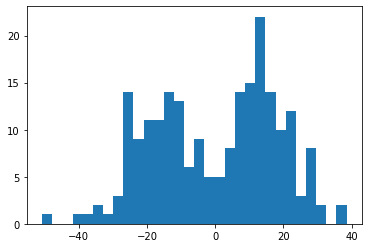

In [6]:
E_kin = -0.5*k*param['T_0']*np.log(np.random.random(size=(N,3)))
p = np.sqrt(2*param['m']*E_kin) * np.random.choice((-1,1), size=(N,3))
p = p - p.mean(0)
kopytko =  plt.hist(p[:,0],bins=30)   # czy na pewno gauss powinien być z wyciętym zerem?

In [7]:
F = np.zeros((N,3),dtype=float)
F, V, P = force_potential_pressure(R, F, param['L'], param['f'], param['e'], param['R'])
T_, P_, H_, ite, t = 0, 0, 0, 0, 0
V

with open(xyz_name,'a') as xyz:
    with open(csv_name,'a') as char:
        for s in tqdm(range(param['S_o']+param['S_d'])):
            t += param['tau']
            p_half = p + F*param['tau']*0.5
            R = R + p_half*param['tau']/param['m']
            F, V, P = force_potential_pressure(R, F, param['L'], param['f'], param['e'], param['R'])
            p = p_half + F*param['tau']*0.5
                        
            E_k = (p**2).sum()/(2*param['m'])
            T = E_k*2/(3*N*k)
            H = E_k + V
            
            if s%param['S_out'] == 0:
                char.write(f'{t},{H},{V},{T},{P}\n')
            
            if s%param['S_xyz'] == 0:
                xyz.write(f'\n{N}\n')
                for i, r in enumerate(R,1):
                    wpisz = f'\n{atom} {r[0]} {r[1]} {r[2]}' if i != N-1 else f'\n{atom} {r[0]} {r[1]} {r[2]}'
                    xyz.write(wpisz)
            
            if s >= param['S_o']:
                T_ += T
                P_ += P
                H_ += H
                
        T_ /= param['S_d']
        P_ /= param['S_d']
        H_ /= param['S_d']
        

100%|██████████| 10100/10100 [03:11<00:00, 52.84it/s]


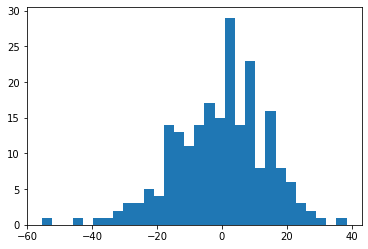

In [8]:
kopytko =  plt.hist(p[:,0],bins=30)

In [9]:
import pandas as pd

data = pd.read_csv(csv_name)

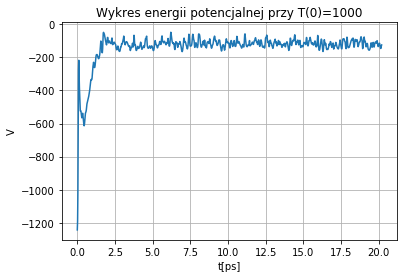

In [10]:
plt.plot(data['t'],data['V'])
plt.xlabel('t[ps]')
plt.ylabel('V')
plt.grid()
plt.title(f"Wykres energii potencjalnej przy T(0)={param['T_0']}")
plt.savefig(f"{name}/V_{param['T_0']}.png",dpi=300)

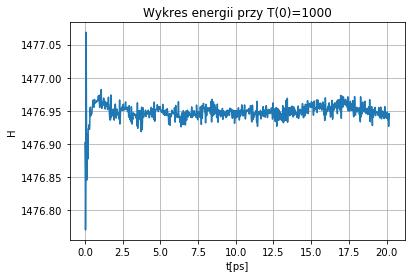

In [11]:
plt.plot(data['t'],data['H'])
plt.xlabel('t[ps]')
plt.ylabel('H')
plt.grid()
plt.title(f"Wykres energii przy T(0)={param['T_0']}")
plt.savefig(f"{name}/H_{param['T_0']}.png",dpi=300)

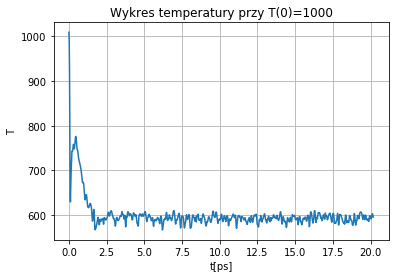

In [12]:
plt.plot(data['t'],data['T'])
plt.xlabel('t[ps]')
plt.ylabel('T')
plt.grid()
plt.title(f"Wykres temperatury przy T(0)={param['T_0']}")
plt.savefig(f"{name}/T_{param['T_0']}.png",dpi=300)

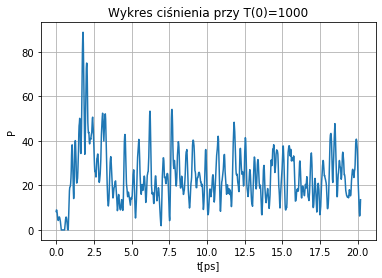

In [13]:
plt.plot(data['t'],data['P'])
plt.xlabel('t[ps]')
plt.ylabel('P')
plt.grid()
plt.title(f"Wykres ciśnienia przy T(0)={param['T_0']}")
plt.savefig(f"{name}/P_{param['T_0']}.png",dpi=300)